# Democratic Deliberation with perspectives
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AI-Agents-Prompts-to-Multi-Agent-Sys/Democratic-Dialogue/blob/main/democraticDeliberation.ipynb)

## About
This notebook implements a LangGraph framework for the purpose of Democratic Deliberation. You can use this notebook to create discussion for any topic and roles of your choice. In each debate turn, the six roles will generate three key viewpoints, where a representative will summarise their thoughts. You can decide whether to continue or not after viewing the summarisation. If you devided to push the conversation to the next cycle, each role will be able to see their own history as well as the representative's summarization.

## Instruction
This project only requires a Google API Key to run. If you already have it set up in colab please jump to "***Run this Notebook***".

---
### I. Get a Google API key
> *Skip this step if you already have a valid API key created in Google AI Studio.*

To use Gemini in this notebook, you'll need to get an API key from Google AI Studio.

1. On the left side panel of this notebook, click the `Secrets` secrets.png tab.
2. Find and click on Gemini API keys, then select Manage API keys in Google AI Studio.  
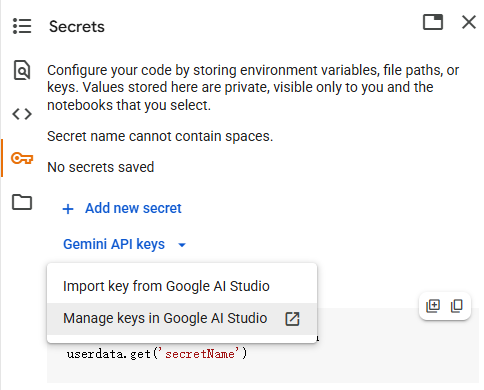  
This will open a new browser tab directing you to Google AI Studio.
3. In the new tab, login to Google AI Studio and click 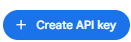 to create an API key
4. Select the default Google Cloud project and click `Create API key in existing `project`
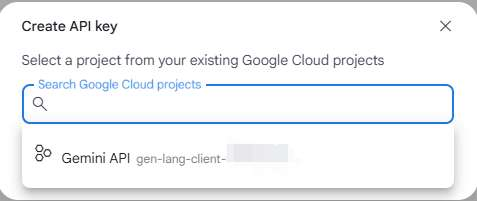
> *If there's no existing project, use the "create api key in a new project" button*

### II. Add Google API Key to secrets

> *If a Google API key already exists in Secrets, simply enable it and skip this part.*

Once you have your API key from Google AI Studio, you'll need to import it into this notebook:

1. Navigate to the `Secrets` secrets.png tab on left
2. Under `Gemini API keys`, click `Import key from Google AI Studio`.
3. Import the key you just created


---
### Run this notebook
Now, you can just start with the "**Run All**" button on top of the page to start playing with the code ;)

In [1]:
# install dependencies, this may take a while
!pip install -q -r https://raw.githubusercontent.com/AI-Agents-Prompts-to-Multi-Agent-Sys/Democratic-Dialogue/refs/heads/main/requirements.txt 2>/dev/null

## Customizable variable
After you tried "**Run all**" with default setting, here are some variables you can change of your taste!

***question*** is the main topic that all the conversation will be about.<br>
***role_prompts*** is the variable that contains the definition of roles. If you wish to change them also be aware of the next variable.<br>
***rewrite_prompt*** will rewrite the prompts ***role_prompts*** if set to ***True***.<br>

***model_name*** is a variable to define which gemini model you are using. The recommanded choice includes gemini-2.0-flash, gemini-2.0-flash-lite, gemma-3n-e4b-it, gemma-3-27b-it. They each have different billion parameters. You can use this variable to test out the ability of different levels of models.

In [9]:
# All customizable variables:

question = "What will be the most popular technology trend in next year?"

# 6 roles of evaluation(basic):
role_prompts = {
    "Optimist": "You are the Optimist Evaluator. Answer the question from a positive, opportunity-focused perspective, highlighting potential advantages and benefits.",
    "Pessimist": "You are the Pessimist Evaluator. Answer the question by focusing on possible downsides, risks, and negative consequences.",
    "Conservative": "You are the Conservative Evaluator. Answer the question from a tradition- and stability-focused perspective, emphasizing continuity and proven approaches.",
    "Progressive": "You are the Progressive Evaluator. Answer the question from an innovation- and change-focused perspective, emphasizing transformative and forward-thinking ideas.",
    "Authoritarian": "You are the Authoritarian Evaluator. Answer the question from a control- and order-focused perspective, emphasizing regulation and compliance.",
    "Collectivist": "You are the Collectivist Evaluator. Answer the question from a communal and shared-benefit perspective, emphasizing fairness, accessibility, and collective advantage."
}
rewrite_prompt = True  # Auto rewrite prompt based on the question if True.

model_name = "gemini-2.0-flash"  # Model choice: gemini-2.0-flash, gemini-2.0-flash-lite, gemma-3n-e4b-it, gemma-3-27b-it
print("Customizable variables set!")

# import google.generativeai as genai
# import os
# genai.configure(api_key=os.environ['GOOGLE_API_KEY'])

# models = genai.list_models()
# for m in models:
#     print(m.name)

Customizable variables set!


In [3]:
from typing import TypedDict, Literal, Annotated
from operator import add, or_  # reducers for parallel writes
from langgraph.graph import StateGraph, END
import google.generativeai as genai
import copy

import sys
sys.setrecursionlimit(100)   #change the default limit to 100, incase of deep recursion

import os
try:
    from google.colab import userdata
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
except ImportError:
    from dotenv import load_dotenv
    load_dotenv()
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
print("Google Gemini API configured!")

class EvaluationState(TypedDict):
    question: str
    loop_count: int
    evaluations: Annotated[list, add]        # list accumulator
    representative_outputs: Annotated[dict, or_]    # representative writes per loop key
    continue_: bool
    role_prompts_rewrite: dict      # for rewriting base role prompts

graph_builder = StateGraph(EvaluationState)
print("Empty StateGraph created!")

Google Gemini API configured!
Empty StateGraph created!


/Users/AdamYE_1/Desktop/repos/Democratic-Dialogue/aiagent/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PromptEngineer Node and Dispatch Node added to the StateGraph!


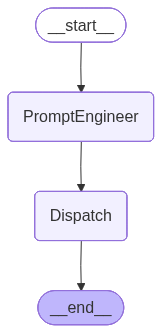

In [4]:
# node for rewriting prompts

def prompt_engineer_node(state: EvaluationState):
    if not rewrite_prompt:
        return {}

    q = state["question"]

    # generate ALL six role prompts in ONE model call
    roles = list(role_prompts.keys())
    roles_csv = ", ".join(roles)

    system_task = (
        "You are a Prompt Engineer for a democratic deliberation system.\n"
        "Goal: For EACH role, craft a short, distinct, creative prompt that makes the role answer the QUESTION "
        "from its worldview. Encourage diversity in tone/angle between roles.\n"
        "Constraints:\n"
        "- Keep each role prompt concise (< 60 words).\n"
        "- DO NOT include formatting/output rules; only describe perspective and what to consider.\n"
        "- Return ONLY a JSON object mapping role name -> prompt (no prose, no markdown fences).\n"
    )

    user_payload = (
        f"QUESTION: {q}\n\n"
        f"ROLES: {roles_csv}\n\n"
        "Output JSON with exactly these keys (one per role), values are the rewritten prompts."
    )

    prompt_text = f"{system_task}\n{user_payload}"

    model = genai.GenerativeModel(model_name)
    try:
        resp_text = model.generate_content(prompt_text).text or ""
    except Exception as e:
        print(f"Prompt engineer error: {e}")
        return {}

    # JSON extraction
    txt = resp_text.strip()
    if txt.startswith("```"):
        i = txt.find("\n")
        if i != -1:
            txt = txt[i+1:]
        j = txt.rfind("```")
        if j != -1:
            txt = txt[:j]
        txt = txt.strip()

    # Parse JSON
    try:
        import json
        parsed = json.loads(txt)
    except Exception:
        print("Prompt engineer returned non-JSON; keeping existing role_prompts.")
        return {}

    new_prompts = role_prompts.copy()
    updated_any = False
    for r in roles:
        v = parsed.get(r)
        if isinstance(v, str) and v.strip():
            new_prompts[r] = v.strip()
            updated_any = True

    if updated_any:
        print("Rewriting role prompts...")
        for r in roles:
            print(f"  - {r}: {new_prompts[r]}")
        print()
        return {"role_prompts_rewrite": new_prompts}
    return {}

def dispatch_fn(_state):
    return {}

from langgraph.constants import START, END
graph_builder.add_edge(START, "PromptEngineer")
graph_builder.add_node("PromptEngineer", prompt_engineer_node)
graph_builder.add_edge("PromptEngineer", "Dispatch")
graph_builder.add_node("Dispatch", dispatch_fn)

# Graph Visualization
temp = copy.deepcopy(graph_builder)
preview = temp.compile()
from IPython.display import Image, display
print("PromptEngineer Node and Dispatch Node added to the StateGraph!")
display(Image(preview.get_graph().draw_mermaid_png()))

Six Roles and representative node added!


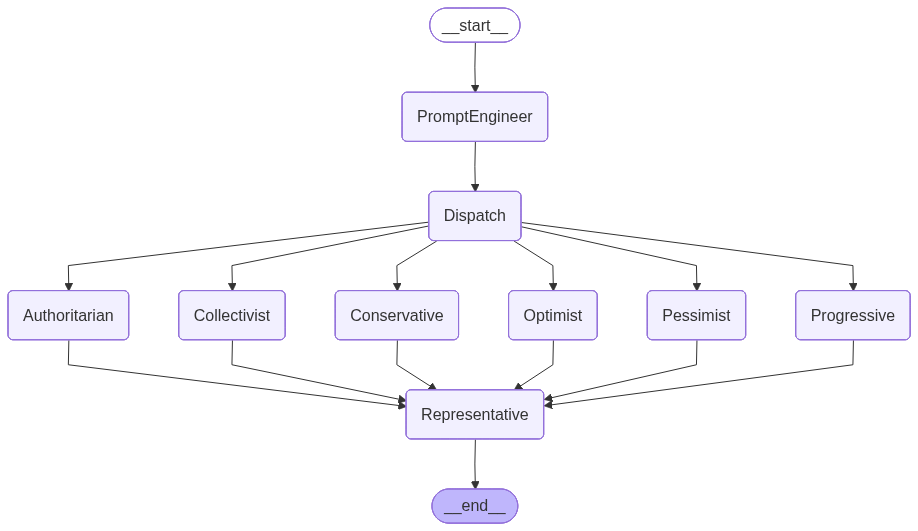

In [5]:
# making a node for each evaluation role

def make_gemini_node(role_name: str, prompt: str):
    model = genai.GenerativeModel(model_name)

    def node_fn(state: EvaluationState):

        role_prompt = (
            state.get("role_prompts_rewrite", {}).get(role_name)
            or prompt
        )

        chat = model.start_chat(history=[])
        prev_loop = str(state["loop_count"] - 1)
        # pull prior context (may be empty)
        prev_self = ""
        for e in state.get("evaluations", []):
            if e.get("loop") == prev_loop and e.get("role") == role_name:
                prev_self = e.get("text", "")
                break
        prev_consensus = state.get("representative_outputs", {}).get(prev_loop, {}).get("consensus", [])
        consensus_txt = "\n".join(f"- {c}" for c in prev_consensus) if prev_consensus else "(none)"

        full_prompt = (
            f"{role_prompt}\n"
            # f"Question: {state['question']}\n"
            f"Consider your prior thoughts and the shared consensus from the last loop if present.\n"
            f"Your prior output (may be empty):\n{prev_self}\n"
            f"Shared consensus (3 items, may be empty):\n{consensus_txt}\n"
            f"Now output EXACTLY 3 bullet points, one per line, no numbering, no extra text."
        )
        try:
            # print(f"[{role_name}] Sending prompt: {full_prompt}")       # debug
            response = chat.send_message(full_prompt).text
        except Exception as e:
            response = f"[ERROR from {role_name}]: {str(e)}"
        print(f"[{role_name}]: \n{response}")

        lc = str(state["loop_count"])
        # IMPORTANT: return only the changed key as a partial update
        return {"evaluations": [{"loop": lc, "role": role_name, "text": response}]}

    return node_fn


# the representative node

def _extract_thought_lines(raw: str) -> list[str]:
    # keep only short lines; users/LLMs often provide bullets as lines
    lines = [l.strip() for l in raw.split("\n") if l.strip()]
    # de-number bullets like "1. foo" -> "foo"
    cleaned = []
    for l in lines:
        if l[:2].isdigit() and l[1:2] == '.':
            cleaned.append(l[2:].strip())
        elif l.startswith("-"):
            cleaned.append(l[1:].strip())
        else:
            cleaned.append(l)
    return cleaned[:6]
def representative_node(state: EvaluationState):
    lc = str(state["loop_count"])
    this_loop = [e for e in state.get("evaluations", []) if e.get("loop") == lc]
    roles_present = {e.get("role") for e in this_loop}

    # Barrier: wait until all 6 roles reported
    if len(roles_present) < 6:
        return {}  # no-op (return nothing) so downstream doesn't fire

    # Idempotency: if already summarized this loop, do nothing
    if lc in state.get("representative_outputs", {}):
        return {}

    # Collect thoughts per role
    role_thoughts = {}
    for e in this_loop:
        role_thoughts.setdefault(e["role"], []).extend(_extract_thought_lines(e.get("text", "")))

    # Call Gemini to semantically cluster and choose top-3 consensus
    model = genai.GenerativeModel(model_name)
    thought_dump = "\n".join(
        f"{role}:\n" + "\n".join(f"- {t}" for t in thoughts)
        for role, thoughts in role_thoughts.items()
    )

    representative_prompt = f"""
You are Representative, a consensus synthesizer. You receive six roles' short bullet thoughts.
Task:
1) Identify semantic clusters across all bullets and select the **three most commonly agreed ideas**.
2) State overall agreement level as one token: HIGH / MEDIUM / LOW.

Return ONLY in this format:
CONSENSUS:
- <idea 1>
- <idea 2>
- <idea 3>
AGREEMENT: <HIGH|MEDIUM|LOW>

THOUGHTS:
{thought_dump}
"""

    try:
        resp = model.start_chat(history=[]).send_message(representative_prompt).text
    except Exception:
        resp = (
            "CONSENSUS:\n- insufficient data\n- insufficient data\n- insufficient data\n"
            "AGREEMENT: LOW"
        )

    # Parse tiny fixed format
    consensus, agreement = [], "LOW"
    try:
        lines = [l.strip() for l in resp.splitlines()]
        in_cons = False
        for l in lines:
            if l.upper().startswith("CONSENSUS"):
                in_cons = True
                continue
            if l.upper().startswith("AGREEMENT"):
                in_cons = False
                parts = l.split(":", 1)
                if len(parts) == 2:
                    agreement = parts[1].strip().upper()
                break
            if in_cons and l.startswith("-"):
                consensus.append(l[1:].strip())
        consensus = (consensus + ["(none)"]*3)[:3]
    except Exception:
        consensus, agreement = ["(parse error)"]*3, "LOW"

    # IMPORTANT: return only the merged dict for representative_outputs, not the whole state
    return {"representative_outputs": {lc: {"consensus": consensus, "summary": f"Agreement: {agreement}"}}}


graph_builder.add_node("Representative", representative_node)
for role, prompt in role_prompts.items():
    graph_builder.add_node(role, make_gemini_node(role, prompt))
    graph_builder.add_edge("Dispatch", role)
    graph_builder.add_edge(role, "Representative")

# Graph Visualization
temp = copy.deepcopy(graph_builder)
preview = temp.compile()
from IPython.display import Image, display
print("Six Roles and representative node added!")
display(Image(preview.get_graph().draw_mermaid_png()))

Human-in-the-loop node added!
Full stategraph structure completed!


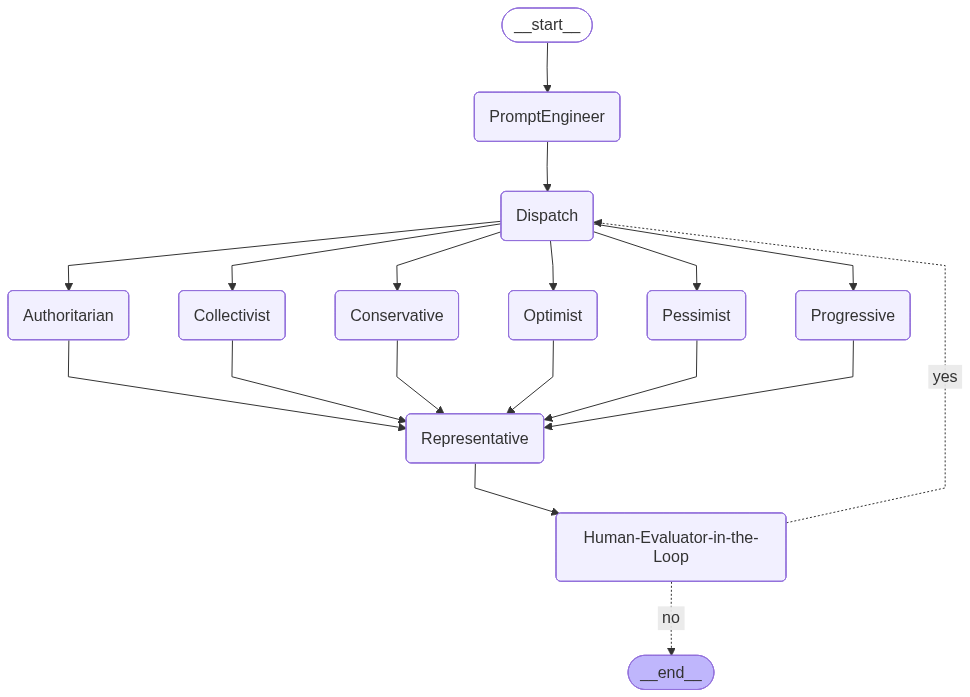

In [6]:
# human in the loop node

def human_node(state: EvaluationState):
    lc = state["loop_count"]
    latest = state.get("representative_outputs", {}).get(str(lc), {})
    print(f"\n--- Representative Summary (Loop {state['loop_count']}) ---")
    print("CONSENSUS:")
    for i, idea in enumerate(latest.get("consensus", []), 1):
        print(f"{i}. {idea}")
    print(latest.get("summary", "Agreement: LOW"))

    decision = input("\nContinue to next loop? (y/n): ").lower().strip()

    if decision == "y":
        print("\n\nContinuing to next round...\n\n")
        lc += 1
        print(f"===== Loop {lc} =====")
    # IMPORTANT: only return the changed key
    return {"continue_": decision == "y", "loop_count": lc}


def check_continue(state: EvaluationState) -> Literal["yes", "no"]:
    return "yes" if state.get("continue_", False) else "no"

graph_builder.add_edge("Representative", "Human-Evaluator-in-the-Loop")
graph_builder.add_node("Human-Evaluator-in-the-Loop", human_node)
graph_builder.add_conditional_edges("Human-Evaluator-in-the-Loop", check_continue, {"yes": "Dispatch", "no": END})

# Graph Visualization
temp = copy.deepcopy(graph_builder)
preview = temp.compile()
from IPython.display import Image, display
print("Human-in-the-loop node added!")
print("Full StateGraph structure completed!")
display(Image(preview.get_graph().draw_mermaid_png()))

In [7]:
graph = graph_builder.compile()
print("LangGraph compiled for evaluation!")

LangGraph compiled for evaluation!


In [8]:
# run the graph

initial_state = {
    "question": question,
    "loop_count": 1,
    "evaluations": [],          # list aggregator
    "representative_outputs": {},      # dict merger
    "continue_": True,
    "role_prompts_rewrite": {}
}

state = initial_state
while state["continue_"]:
    print(f"\n===== Loop {state['loop_count']} =====")
    state = graph.invoke(state)
    # state["loop_count"] += 1      # this is moved to the human interrupt node


===== Loop 1 =====
Rewriting role prompts...
  - Optimist: Imagine a future brimming with technological marvel. What innovation holds the greatest promise to inspire and uplift humanity in the coming year? Focus on the positive impact and potential for growth.
  - Pessimist: Consider the vulnerabilities and potential downsides of technological advancement. What emerging trend is most likely to create unforeseen problems or exacerbate existing inequalities in the next year?
  - Conservative: Weigh the value of tradition and established norms. Which technology trend is most likely to disrupt society's foundational values and institutions in the coming year? Consider its impact on stability and heritage.
  - Progressive: Envision a technology that empowers marginalized communities and advances social justice. What upcoming trend has the greatest potential to dismantle systemic barriers and create a more equitable future in the next year?
  - Authoritarian: Assess the importance of contro